In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
cd /content/drive/MyDrive/AI/.kaggle

/content/drive/MyDrive/AI/.kaggle


In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
import os
import cv2
import random
from PIL import Image
from sklearn.model_selection import train_test_split

In [111]:
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(1)
    tf.random.set_seed(1)
    np.random.seed(1)
    random.seed(1)

reset_random_seeds()

In [112]:
path = "/content/drive/MyDrive/AI/.kaggle/UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[550])

Total samples: 12983
30_0_0_20170120220636164.jpg.chip.jpg


(64, 64, 3)

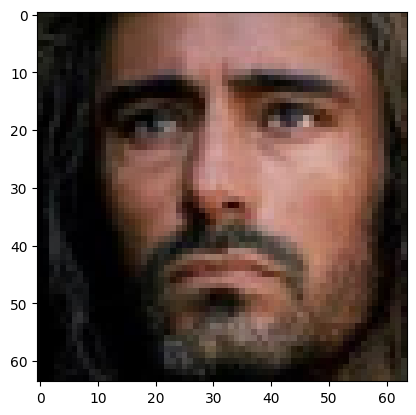

In [113]:
img = cv2.imread(os.path.join(path,files[550]))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,dsize=(64,64))
img = img/255.0
plt.imshow(img)
img.shape

In [121]:
images = []
ages = []
genders = []
for file in files:
    age = file.split("_")[0]
    gender = file.split("_")[1]
    img = cv2.imread(path+file)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,dsize=(64,64))
    img = img/255.0
    images.append(np.array(img))
    ages.append(np.array(int(age)))
    genders.append(np.array(int(gender)))

In [128]:
ages = np.array(ages,dtype=np.int64)
images = np.array(images,dtype=np.float32) 
genders = np.array(genders,np.uint64)
ages.max(),ages.min()

(116, 1)

In [129]:
print(ages)
ages = ages/ages.max()
ages.max(),ages.min()

[24 24 24 ... 15 15 15]


(1.0, 0.008620689655172414)

Age = 0.20689655172413793
Gender = Male
1.0 0.0
(64, 64, 3)


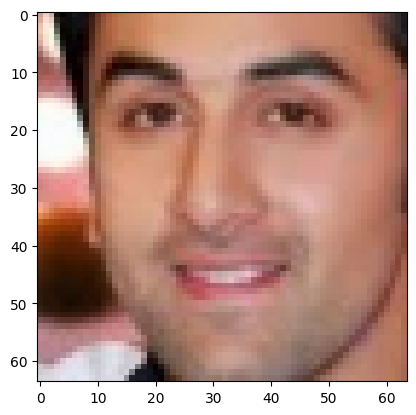

In [130]:
ix = 2
plt.imshow(images[ix],cmap='gray')
print(f"Age = {ages[ix]}")
if genders[ix] == 0:
  print(f"Gender = Male")
else:
  print(f"Gender = Female")
print(images[ix].max(), images[ix].min())
print(images[ix].shape)

In [132]:
# pre processing
target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,64,64,3),dtype = 'float32')

target[:,0] = ages
target[:,1] = genders
features = images

Age = 0.2068965584039688
Gender = Male
1.0 0.0
(64, 64, 3)


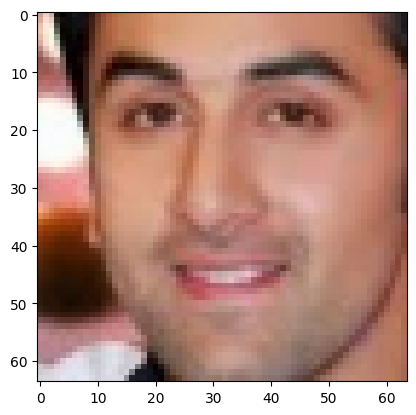

In [133]:
ix = 2
plt.imshow(features[ix],cmap='gray')
print(f"Age = {target[ix,0]}")
if target[ix,1] == 0:
  print(f"Gender = Male")
else:
  print(f"Gender = Female")
print(features[ix].max(), features[ix].min())
print(features[ix].shape)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle= True, random_state=42)
print("Samples in Training:",X_train.shape[0])
print("Samples in Testing:",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Samples in Training: 10386
Samples in Testing: 2597
(10386, 64, 64, 3)
(2597, 64, 64, 3)
(10386, 2)
(2597, 2)


In [135]:
from tensorflow.keras.applications import MobileNet

base = MobileNet(weights='imagenet',include_top=False,input_shape=(64, 64,3))

for layer in base.layers:
    layer.trainable = False

drop_rate = 0.3

#base.summary()
inputs = tf.keras.layers.Input((64,64,3))
x = base(inputs)
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
#x = tf.keras.layers.Dropout(0.25)(x)



age_model = tf.keras.layers.Dense(64, activation='relu')(x)
age_model = tf.keras.layers.BatchNormalization()(age_model)
age_model = tf.keras.layers.Dropout(drop_rate)(age_model)
age_model = tf.keras.layers.Dense(32, activation='relu')(age_model)
age_model = tf.keras.layers.BatchNormalization()(age_model)
age_model = tf.keras.layers.Dropout(drop_rate)(age_model)
age_model = tf.keras.layers.Dense(16, activation='relu')(age_model)
age_model = tf.keras.layers.BatchNormalization()(age_model)
age_model = tf.keras.layers.Dropout(drop_rate)(age_model)
age_model = tf.keras.layers.Dense(8, activation='relu')(age_model)
age_model = tf.keras.layers.BatchNormalization()(age_model)
#age_model = tf.keras.layers.Dropout(drop_rate)(age_model)
age_model = tf.keras.layers.Dense(1, activation='relu',name='age')(age_model)



gender_model = tf.keras.layers.Dense(64, activation='relu')(x)
gender_model = tf.keras.layers.BatchNormalization()(gender_model)
gender_model = tf.keras.layers.Dropout(drop_rate)(gender_model)
gender_model = tf.keras.layers.Dense(32, activation='relu')(gender_model)
gender_model = tf.keras.layers.BatchNormalization()(gender_model)
gender_model = tf.keras.layers.Dropout(drop_rate)(gender_model)
gender_model = tf.keras.layers.Dense(16, activation='relu')(gender_model)
gender_model = tf.keras.layers.BatchNormalization()(gender_model)
gender_model = tf.keras.layers.Dropout(drop_rate)(gender_model)
gender_model = tf.keras.layers.Dense(8, activation='relu')(gender_model)
gender_model = tf.keras.layers.BatchNormalization()(gender_model)
gender_model = tf.keras.layers.Dense(4, activation='relu')(gender_model)
gender_model = tf.keras.layers.BatchNormalization()(gender_model)
#gender_model = tf.keras.layers.Dropout(drop_rate)(gender_model)
gender_model = tf.keras.layers.Dense(1, activation='sigmoid',name='gender')(gender_model)

model = tf.keras.Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam',
              loss ={'age':'mse', 'gender':'binary_crossentropy'},
              metrics={'age':'mae', 'gender':'accuracy'})

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 mobilenet_1.00_224 (Functional  (None, 2, 2, 1024)  3228864     ['input_6[0][0]']                
 )                                                                                                
                                                                                                  
 flatten_2 (Flatten)            (None, 4096)         0           ['mobilenet_1.00_224[0][0]']     
                                                                                                  
 dense_22 (Dense)               (None, 64)           262208      ['flatten_2[0][0]']        

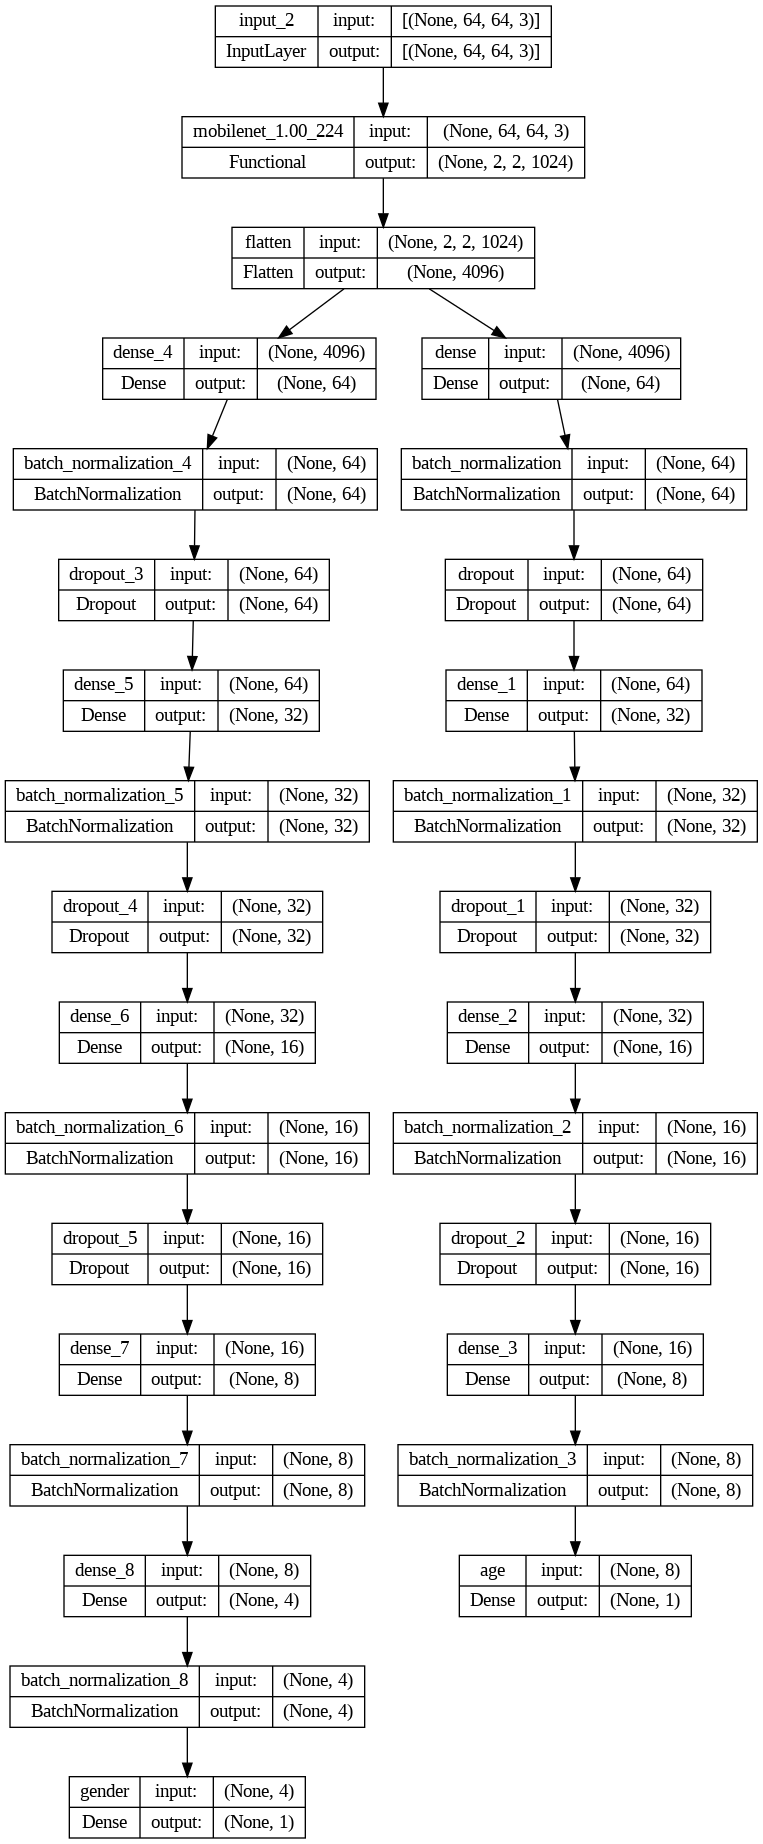

In [17]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [136]:
history = model.fit(X_train,[y_train[:,0],y_train[:,1]],validation_data=(X_test,[y_test[:,0],y_test[:,1]]),epochs = 10, batch_size=32,shuffle = True)

Epoch 1/10
325/325 [==============================] - 18s 24ms/step - loss: 0.6918 - age_loss: 0.0911 - gender_loss: 0.6007 - age_mae: 0.2208 - gender_accuracy: 0.7018 - val_loss: 0.5168 - val_age_loss: 0.0442 - val_gender_loss: 0.4725 - val_age_mae: 0.1860 - val_gender_accuracy: 0.7821
Epoch 2/10
325/325 [==============================] - 7s 21ms/step - loss: 0.5076 - age_loss: 0.0429 - gender_loss: 0.4647 - age_mae: 0.1817 - gender_accuracy: 0.7820 - val_loss: 0.4596 - val_age_loss: 0.0446 - val_gender_loss: 0.4150 - val_age_mae: 0.1906 - val_gender_accuracy: 0.8152
Epoch 3/10
325/325 [==============================] - 6s 17ms/step - loss: 0.4717 - age_loss: 0.0407 - gender_loss: 0.4311 - age_mae: 0.1753 - gender_accuracy: 0.7992 - val_loss: 0.4390 - val_age_loss: 0.0403 - val_gender_loss: 0.3986 - val_age_mae: 0.1778 - val_gender_accuracy: 0.8094
Epoch 4/10
325/325 [==============================] - 7s 21ms/step - loss: 0.4401 - age_loss: 0.0361 - gender_loss: 0.4040 - age_mae: 0.16

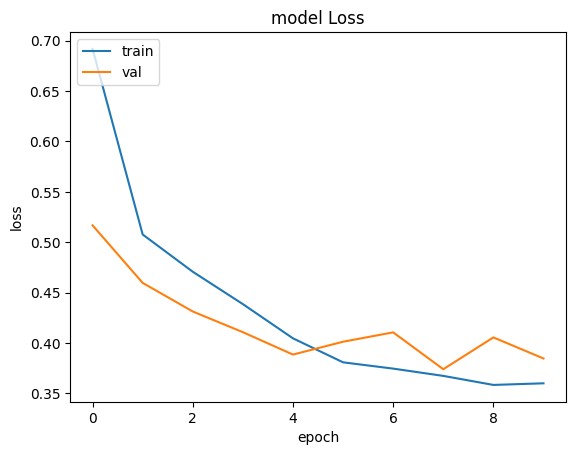

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

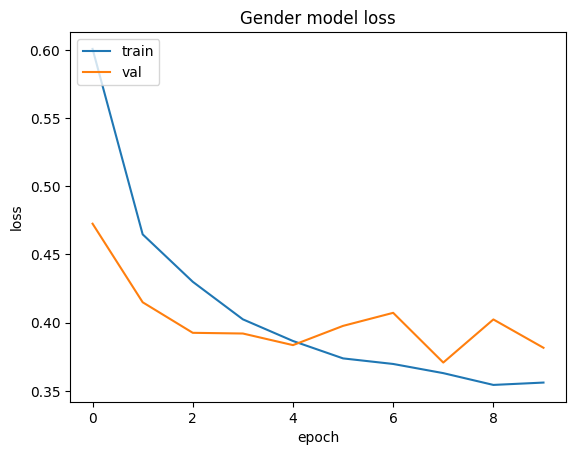

In [20]:
plt.plot(history.history['gender_loss'])
plt.plot(history.history['val_gender_loss'])
plt.title('Gender model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

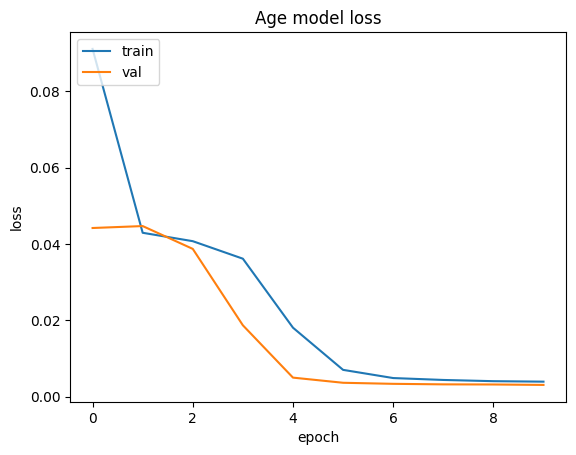

In [21]:
plt.plot(history.history['age_loss'])
plt.plot(history.history['val_age_loss'])
plt.title('Age model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

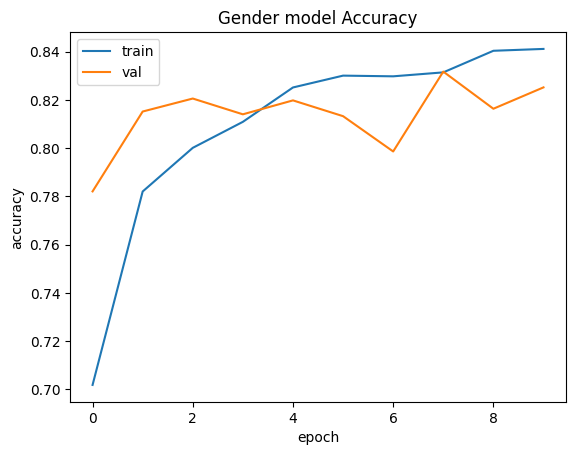

In [22]:
plt.plot(history.history['gender_accuracy'])
plt.plot(history.history['val_gender_accuracy'])
plt.title('Gender model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

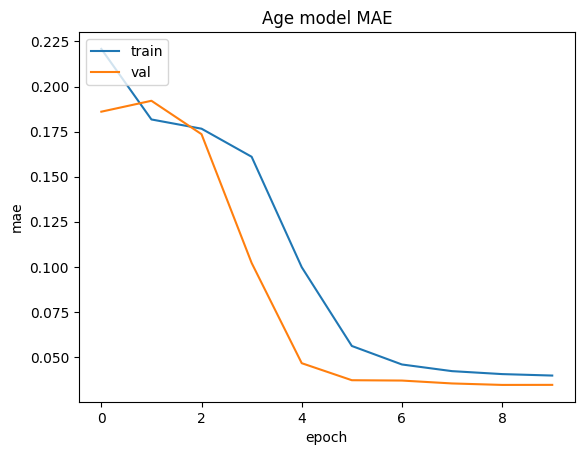

In [23]:
plt.plot(history.history['age_mae'])
plt.plot(history.history['val_age_mae'])
plt.title('Age model MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [137]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
    
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"
    
def get_gender(prob):
    if prob < 0.5: return "Male"
    else:          return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )    
    age = int(val[0][0][0])
    gender = get_gender(val[1])
    print("Values:",val,"\nPredicted Age:",age,",Predicted Gender :",gender)

In [138]:
def Test_img_generator(file_path):
  img = cv2.imread(file_path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,dsize=(64,64))
  img = img/255.0
  return img

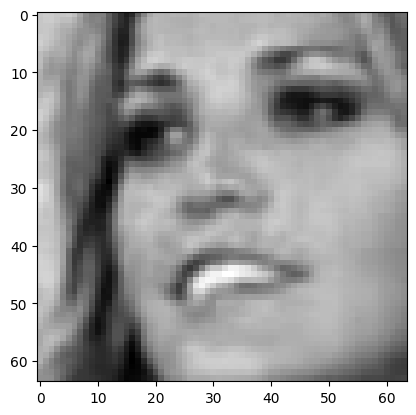

1/1 [==============================] - 1s 613ms/step
Values: [array([[0.18764448]], dtype=float32), array([[0.40158877]], dtype=float32)] 
Predicted Age: 0 ,Predicted Gender : Male


In [139]:
sample = Test_img_generator("/content/drive/MyDrive/AI/AI_Project/FaceTest/test3.jpg")
display(sample)
get_result(sample)

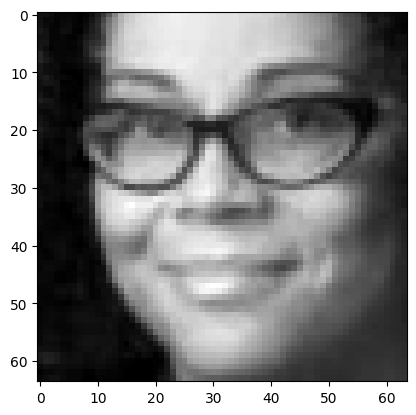

Actual Age: 0.21551724137931033 , Gender : Female
1/1 [==============================] - 0s 23ms/step
Values: [array([[0.19269127]], dtype=float32), array([[0.3904638]], dtype=float32)] 
Predicted Age: 0 ,Predicted Gender : Male


In [140]:
indexes = [100]
for idx in indexes:
    sample = images[idx]
    display(sample)
    print("Actual Age:",ages[idx],", Gender :",get_gender(genders[idx]))
    get_result(sample)